In [1]:
import pandas as pd
import plotly.express as px

In [2]:
df = pd.read_csv('static_google_transit/stop_times.txt')
stop_names_df = pd.read_csv('static_google_transit/stops.txt')
station_mapping = pd.read_csv('intermediate_dataset/unique_stops.csv')

# Stop Names and Transfer Stations

In [3]:
stop_names_df['parent_station'] = stop_names_df['parent_station'].fillna(stop_names_df['stop_id'])

In [4]:
composite_stop_names_df = stop_names_df.merge(station_mapping[['stop_id','composite_gtfs_stops_id']],
                                              left_on='parent_station',
                                              right_on='stop_id',
                                              how='left',
                                              suffixes=('','_')
                                             )

In [5]:
composite_stop_names_df.to_csv('intermediate_dataset/composite_stop_names.csv')

In [6]:
composite_stop_names_df.loc[composite_stop_names_df['parent_station'] == '725']

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,stop_id_,composite_gtfs_stops_id
525,725,Times Sq-42 St,40.755477,-73.987691,1.0,725,725,127_725_902_A27_R16
526,725N,Times Sq-42 St,40.755477,-73.987691,NaN,725,725,127_725_902_A27_R16
527,725S,Times Sq-42 St,40.755477,-73.987691,NaN,725,725,127_725_902_A27_R16


# Unique Trips

In [7]:
df['trip_id'].unique().shape

(20060,)

# Extract Route, Stop Id, Day of Week, Direction

* Extract Routes is simple enough
  
* Not sure why day of week is missing sometimes

In [8]:
def extract_route(e):
    return e.split('_')[-1].split('.')[0]

def extract_day_of_week(e):
    day_of_week_types = ['Saturday','Sunday','Weekday']
    for dow_type in day_of_week_types:
        if dow_type in e:
            return dow_type

def extract_stop_id(e):
    return e[:-1]

def extract_direction(e):
    return e[-1]
    
def extract_leading_key(e):
    return '-'.join(e.split('-')[:3])

def extract_time(e):
    return datetime.datetime.strptime(e, '%H:%M:%S')

def convert_from_27_hour_cycle_to_24_hour_cycle(row, time_type='departure_time'):
    def convert_to_24_hour_cycle(row):
        return row[time_type+'_hour'] + row[time_type][2:] 
    return convert_to_24_hour_cycle

# Adjust Departure and Arrival Times to operate on 24 hour clock
for transist_time in ['departure_time','arrival_time']:
    df[transist_time + '_hour'] = df[transist_time].apply(lambda x: x[:2]).astype(int)
    df[transist_time + '_hour'] = (df[transist_time + '_hour'] % 24).apply(lambda x: "{:02d}".format(x))
    
departure_convert = convert_from_27_hour_cycle_to_24_hour_cycle('departure_time')
arrival_convert = convert_from_27_hour_cycle_to_24_hour_cycle('arrival_time')
df['arrival_time_24_hour_cycle'] = df.apply(arrival_convert, axis=1)
df['departure_time_24_hour_cycle'] = df.apply(departure_convert, axis=1)

# df['departure_time_t_of_day'] = df['departure_time_t'].dt.time

df['route'] = df['trip_id'].apply(extract_route)
df['dow_type'] = df['trip_id'].apply(extract_day_of_week)
df['GTFS_stop_id'] = df['stop_id'].apply(extract_stop_id)
df['direction'] = df['stop_id'].apply(extract_direction)
df['leading_key'] = df['trip_id'].apply(extract_leading_key)

In [9]:
df['GTFS_stop_id'].unique().shape

(496,)

## Departure time after 24 hours

* Does MTA use a special time format to go beyond 24 hours?
* https://groups.google.com/g/transit-developers/c/ZkfnuNv1gho?pli=1
* MTA operates on a 27 hour cycle

In [10]:
df.loc[df['trip_id'] == 'SIR-FA2017-SI017-Weekday-08_147100_SI..N03R']

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,departure_time_hour,arrival_time_hour,arrival_time_24_hour_cycle,departure_time_24_hour_cycle,route,dow_type,GTFS_stop_id,direction,leading_key
557244,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S09N,24:31:00,24:31:00,1,00,00,00:31:00,00:31:00,SI,Weekday,S09,N,SIR-FA2017-SI017
557245,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S11N,24:34:00,24:34:00,2,00,00,00:34:00,00:34:00,SI,Weekday,S11,N,SIR-FA2017-SI017
557246,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S13N,24:36:00,24:36:00,3,00,00,00:36:00,00:36:00,SI,Weekday,S13,N,SIR-FA2017-SI017
557247,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S14N,24:38:00,24:38:00,4,00,00,00:38:00,00:38:00,SI,Weekday,S14,N,SIR-FA2017-SI017
557248,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S15N,24:40:00,24:40:00,5,00,00,00:40:00,00:40:00,SI,Weekday,S15,N,SIR-FA2017-SI017
557249,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S16N,24:42:00,24:42:00,6,00,00,00:42:00,00:42:00,SI,Weekday,S16,N,SIR-FA2017-SI017
557250,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S17N,24:44:00,24:44:00,7,00,00,00:44:00,00:44:00,SI,Weekday,S17,N,SIR-FA2017-SI017
557251,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S18N,24:46:00,24:46:00,8,00,00,00:46:00,00:46:00,SI,Weekday,S18,N,SIR-FA2017-SI017
557252,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S19N,24:48:00,24:48:00,9,00,00,00:48:00,00:48:00,SI,Weekday,S19,N,SIR-FA2017-SI017
557253,SIR-FA2017-SI017-Weekday-08_147100_SI..N03R,S20N,24:50:00,24:50:00,10,00,00,00:50:00,00:50:00,SI,Weekday,S20,N,SIR-FA2017-SI017


## Arrival and Departure Times

* Anticipated Layovers

In [11]:
df.loc[df['arrival_time'] != df['departure_time']]

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,departure_time_hour,arrival_time_hour,arrival_time_24_hour_cycle,departure_time_24_hour_cycle,route,dow_type,GTFS_stop_id,direction,leading_key
34,AFA23GEN-1038-Sunday-00_000600_1..S03R,137S,00:56:00,00:59:00,35,00,00,00:59:00,00:59:00,1,Sunday,137,S,AFA23GEN-1038-Sunday
72,AFA23GEN-1038-Sunday-00_002600_1..S03R,137S,01:16:00,01:19:00,35,01,01,01:19:00,01:19:00,1,Sunday,137,S,AFA23GEN-1038-Sunday
110,AFA23GEN-1038-Sunday-00_004600_1..S03R,137S,01:36:00,01:39:00,35,01,01,01:39:00,01:39:00,1,Sunday,137,S,AFA23GEN-1038-Sunday
148,AFA23GEN-1038-Sunday-00_006600_1..S03R,137S,01:56:00,01:59:00,35,01,01,01:59:00,01:59:00,1,Sunday,137,S,AFA23GEN-1038-Sunday
188,AFA23GEN-1038-Sunday-00_007200_1..N03R,103N,02:06:00,02:09:00,37,02,02,02:09:00,02:09:00,1,Sunday,103,N,AFA23GEN-1038-Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546873,L0S3-7-3026-S02_092200_7..S97R,725S,15:55:30,15:56:30,21,15,15,15:56:30,15:56:30,7,None,725,S,L0S3-7-3026
546917,L0S3-7-3026-S02_092700_7..S97R,725S,16:00:30,16:01:30,21,16,16,16:01:30,16:01:30,7,None,725,S,L0S3-7-3026
555280,SIR-FA2017-SI017-Weekday-08_043600_SI..S07R,S19S,07:32:00,07:34:00,2,07,07,07:34:00,07:34:00,SI,Weekday,S19,S,SIR-FA2017-SI017
555316,SIR-FA2017-SI017-Weekday-08_045100_SI..S07R,S19S,07:47:00,07:49:00,2,07,07,07:49:00,07:49:00,SI,Weekday,S19,S,SIR-FA2017-SI017


## Routes

In [12]:
df.groupby('route').agg(
    unique = ('trip_id','nunique')
)


,unique
route,
1,1142
2,848
3,722
4,904
5,747
6,1210
7,1454
A,936
B,196


## Day of Week Types

In [13]:
df.groupby('dow_type').agg(
    unique = ('trip_id','nunique')
)

,unique
dow_type,
Saturday,5674
Sunday,5178
Weekday,7475


In [14]:
df['null_dow_type'] = df['dow_type'].isnull()

In [15]:
df.loc[df['null_dow_type'] == True]

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,departure_time_hour,arrival_time_hour,arrival_time_24_hour_cycle,departure_time_24_hour_cycle,route,dow_type,GTFS_stop_id,direction,leading_key,null_dow_type
511235,L0S1-7-1064-S02_001150_7..S97R,701S,00:11:30,00:11:30,1,00,00,00:11:30,00:11:30,7,None,701,S,L0S1-7-1064,True
511236,L0S1-7-1064-S02_001150_7..S97R,702S,00:14:00,00:14:00,2,00,00,00:14:00,00:14:00,7,None,702,S,L0S1-7-1064,True
511237,L0S1-7-1064-S02_001150_7..S97R,705S,00:15:30,00:15:30,3,00,00,00:15:30,00:15:30,7,None,705,S,L0S1-7-1064,True
511238,L0S1-7-1064-S02_001150_7..S97R,706S,00:16:30,00:16:30,4,00,00,00:16:30,00:16:30,7,None,706,S,L0S1-7-1064,True
511239,L0S1-7-1064-S02_001150_7..S97R,707S,00:17:30,00:17:30,5,00,00,00:17:30,00:17:30,7,None,707,S,L0S1-7-1064,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550544,L0S3-7-3026-S02_148800_7..N97R,707N,25:16:00,25:16:00,18,01,01,01:16:00,01:16:00,7,None,707,N,L0S3-7-3026,True
550545,L0S3-7-3026-S02_148800_7..N97R,706N,25:17:00,25:17:00,19,01,01,01:17:00,01:17:00,7,None,706,N,L0S3-7-3026,True
550546,L0S3-7-3026-S02_148800_7..N97R,705N,25:18:00,25:18:00,20,01,01,01:18:00,01:18:00,7,None,705,N,L0S3-7-3026,True
550547,L0S3-7-3026-S02_148800_7..N97R,702N,25:20:00,25:20:00,21,01,01,01:20:00,01:20:00,7,None,702,N,L0S3-7-3026,True


## Station Id

In [16]:
df.groupby('GTFS_stop_id').agg(
    unique = ('trip_id','nunique')
)


,unique
GTFS_stop_id,
101,1112
103,1128
104,1128
106,1128
107,1132
...,...
S27,313
S28,313
S29,313


# Building Distance Matrix

Assumptions:
* There is a single aggregate measure of time between stations (Stop A to Stop B takes 5 minutes on average)
* The next train is immediately available
* Only Including Weekday Routes

Problem Statement:
For a given station, I want to know the transit time to visit any other station on a given weekday.

To approximate the transit time, I want to know the expected frequency of a train from a given station. 8 minutes per train.

In [17]:
weekday_train_schedules = df.loc[(df['dow_type'] == 'Weekday') | (df['dow_type'].isnull())]
weekday_train_schedules = weekday_train_schedules.loc[weekday_train_schedules['route'] != 'SI']

In [18]:
composite_stop_names_df

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,stop_id_,composite_gtfs_stops_id
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583,1.0,101,101,101
1,101N,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101,101,101
2,101S,Van Cortlandt Park-242 St,40.889248,-73.898583,NaN,101,101,101
3,103,238 St,40.884667,-73.900870,1.0,103,103,103
4,103N,238 St,40.884667,-73.900870,NaN,103,103,103
...,...,...,...,...,...,...,...,...
1492,S30N,Tompkinsville,40.636949,-74.074835,NaN,S30,S30,S30
1493,S30S,Tompkinsville,40.636949,-74.074835,NaN,S30,S30,S30
1494,S31,St George,40.643748,-74.073643,1.0,S31,S31,S31
1495,S31N,St George,40.643748,-74.073643,NaN,S31,S31,S31


In [19]:
weekday_train_schedules = weekday_train_schedules.merge(composite_stop_names_df[['stop_id','composite_gtfs_stops_id']], on='stop_id')

In [20]:
weekday_train_schedules['GTFS_stop_id'].unique().shape

(475,)

## Approximate Frequency of Trains at Each Stop

In [21]:
hour_cycle = 27

trains_per_stop_route_direction = weekday_train_schedules.groupby(['stop_id','route', 'direction'], as_index=False).agg(
    n_trains = ('trip_id', 'nunique'),
    
)

trains_per_stop_route_direction['n_trains_per_hour'] = trains_per_stop_route_direction['n_trains'] / hour_cycle
trains_per_stop_route_direction['n_minutes_per_train'] = (hour_cycle * 60) / trains_per_stop_route_direction['n_trains']
trains_per_stop_route_direction['n_seconds_per_train'] = (hour_cycle * 60 * 60) / trains_per_stop_route_direction['n_trains']

In [22]:
routes_per_stop_direction = weekday_train_schedules.groupby(['stop_id', 'direction'], as_index=False).agg(
    n_routes = ('route', 'nunique')
)
routes_per_stop_direction.sort_values('n_routes', ascending=False)

,stop_id,direction,n_routes
916,R30S,S,5
915,R30N,N,5
393,A24S,S,4
464,B08N,N,4
147,239S,S,4
...,...,...,...
449,A59S,S,1
448,A59N,N,1
447,A57S,S,1
446,A57N,N,1


In [23]:
trains_per_stop_route_direction.loc[(trains_per_stop_route_direction['stop_id'] == '235N') & (trains_per_stop_route_direction['direction'] == 'N')]

,stop_id,route,direction,n_trains,n_trains_per_hour,n_minutes_per_train,n_seconds_per_train
250,235N,2,N,162,6.000000,10.000000,600.000000
251,235N,3,N,129,4.777778,12.558140,753.488372
252,235N,4,N,182,6.740741,8.901099,534.065934
253,235N,5,N,122,4.518519,13.278689,796.721311


## Travel Time Between Each Stop

For a given station, I want to know the transit time to any other station.

In [24]:
weekday_train_schedules['previous_departure_time_24_hour_cycle'] = weekday_train_schedules.groupby('trip_id')['departure_time_24_hour_cycle'].shift(1)
weekday_train_schedules['next_departure_time_24_hour_cycle'] = weekday_train_schedules.groupby('trip_id')['departure_time_24_hour_cycle'].shift(-1)
weekday_train_schedules['next_composite_gtfs_stops_id'] = weekday_train_schedules.groupby('trip_id')['composite_gtfs_stops_id'].shift(-1)

# Arrival Time - Previous_Departure_Time yields Transit Time
weekday_train_schedules['n_seconds_in_transit'] = (pd.to_datetime(weekday_train_schedules['next_departure_time_24_hour_cycle']) - pd.to_datetime(weekday_train_schedules['arrival_time_24_hour_cycle'])).dt.seconds

In [25]:
weekday_train_schedules.loc[weekday_train_schedules['route'] == '7']['GTFS_stop_id'].unique()

array(['701', '702', '705', '706', '707', '708', '709', '710', '711',
       '712', '713', '714', '715', '716', '718', '719', '720', '721',
       '723', '724', '725', '726'], dtype=object)

In [26]:
weekday_train_schedules.loc[weekday_train_schedules['route'] == '7']['composite_gtfs_stops_id'].unique()

array(['701', '702', '705', '706', '707', '708', '709', '710_G14', '711',
       '712', '713', '714', '715', '716', '718_R09', '719_F09_G22', '720',
       '721', '631_723_901', '724_D16', '127_725_902_A27_R16', '726'],
      dtype=object)

In [27]:
edge_transit = weekday_train_schedules.groupby(['composite_gtfs_stops_id','next_composite_gtfs_stops_id','route','direction'], as_index=False).agg(
    n_trips_between_stop = ('trip_id','nunique'),
    mean_seconds_in_transit = ('n_seconds_in_transit','mean'),
)

print(weekday_train_schedules['n_seconds_in_transit'].min())
print(weekday_train_schedules['n_seconds_in_transit'].max())

30.0
86340.0


In [28]:
edge_transit.loc[edge_transit['composite_gtfs_stops_id'] == edge_transit['next_composite_gtfs_stops_id']]

,composite_gtfs_stops_id,next_composite_gtfs_stops_id,route,direction,n_trips_between_stop,mean_seconds_in_transit


## Graph of New York Passenger Subway and Rail

Assumptions:
* Going North and Going South from two stops are not equal
* The time spent in transit from Station A to Station B is not equal to the time spent in transit from Station B to Station A


In [29]:
weighted_edges = edge_transit[['composite_gtfs_stops_id','next_composite_gtfs_stops_id','mean_seconds_in_transit']].to_dict(orient='records')
edge_transit[['composite_gtfs_stops_id','next_composite_gtfs_stops_id','route','direction','mean_seconds_in_transit']].to_csv('intermediate_dataset/edge_transit.csv', index=False)

weighted_edges = list(map(lambda x: (x['composite_gtfs_stops_id'], x['next_composite_gtfs_stops_id'], x['mean_seconds_in_transit']), weighted_edges))

In [30]:
import networkx as nx

In [31]:
G = nx.DiGraph()

G.add_weighted_edges_from(weighted_edges)

In [33]:
def get_lat_long(stop_id):
    stop_info = composite_stop_names_df.loc[composite_stop_names_df['composite_gtfs_stops_id'] == stop_id]
    assert stop_info.shape[0] > 0
    return list(stop_info[['stop_lon','stop_lat']].values[0])

In [34]:
train_schedule_stop_ids = weekday_train_schedules['stop_id'].unique()

In [35]:
lat_long = {k:get_lat_long(k) for k,v in G.nodes(data=True)}

In [36]:
len(G.edges)

1133

Text(0.5, 1.0, 'NYC Subway Network')

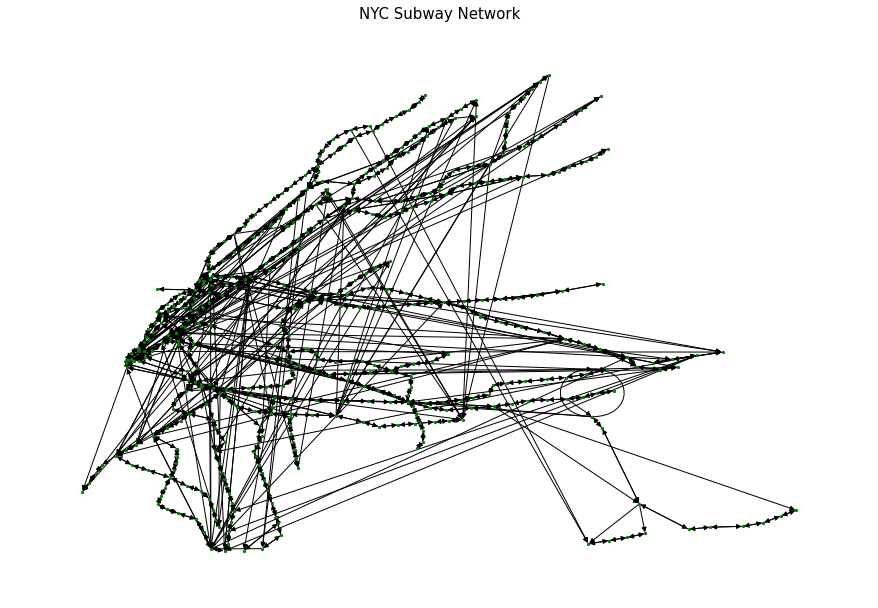

In [37]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
nx.draw(G, pos=lat_long, edge_color='black', node_size=5, node_color='green')
plt.title('NYC Subway Network', size=15)

## Calculating Distance Matrix based on Travel Time

* How to Debug if a path does not exist?
* I think every node is connected

In [38]:
import itertools

set_of_all_stations = list(G.nodes)

In [39]:
pairs_of_stations = list(itertools.product(set_of_all_stations, set_of_all_stations))

In [40]:
distance_matrix = [(pair[0], pair[1], nx.shortest_path_length(G, pair[0], pair[1], 'weight')) for pair in pairs_of_stations]

NetworkXNoPath: Node 101 not reachable from R45

In [ ]:
distance_matrix_df = pd.DataFrame(distance_matrix, columns=['composite_gtfs_id','next_composite_gtfs_id','seconds'])

In [ ]:
distance_matrix_df.to_csv('intermediate_dataset/distance_time_matrix.csv', index=False)